# Pipeline of running CNMF-E 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os.path
from caiman.gui import caiman_gui as cmg 
from caiman.source_extraction.cnmf_e import cnmfe
import caiman.source_extraction.cnmf.pre_processing as data_processing
import importlib
import matplotlib.animation as animation
from datetime import datetime
from collections import OrderedDict
import json
import caiman as cm
import cv2
import caiman.source_extraction.cnmf.deconvolution as deconvolve

importlib.reload(cnmfe)
importlib.reload(cmg)
importlib.reload(deconvolve)

<module 'caiman.source_extraction.cnmf.deconvolution' from '/Users/zhoupc/Dropbox/Liam/caiman/caiman/source_extraction/cnmf/deconvolution.py'>

## Step 0: Create an instance of cnmfe.Sources2D 

In [2]:
pars4user = cnmfe.default_pars()
pars4user['neuron']['neuron diameter'] = 10
pars4user['neuron']['gaussian width'] = 3
pars4user['initialization']['z-score threshold'] = 3
neuron = cnmfe.Sources2D(pars=pars4user)
# neuron.show_parameters()  # show parameters 

## Step 1: Load data 


-------------------------Loading data-------------------------
Dimension: 128 X 128 pixels X 1000 frames
The result folder has been created
The results will be saved into folder /Users/zhoupc/Dropbox/Liam/caiman/example_movies/data_endoscope_caiman

-------------------------Done-------------------------



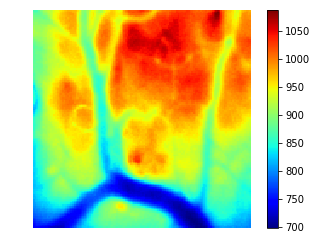

In [3]:
fname = './example_movies/data_endoscope.tif'
Y = neuron.load_file(fname)

# OR load data in GUI mode 
# Y = neuron.ui_get_file()
# %matplotlib qt 
%matplotlib inline
neuron.image(Y[100,], colorbar=True, axis=False)

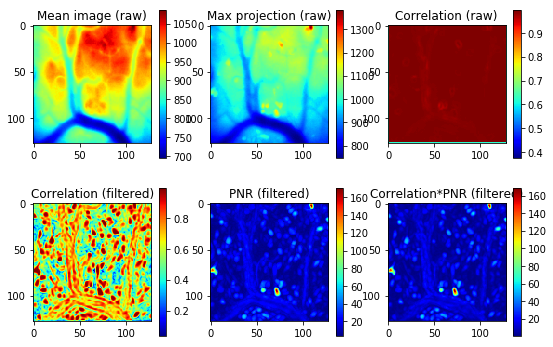

In [4]:
# show correlation image of the raw data; show correlation image and PNR image of the filtered data
cn_raw = cnmfe.local_correlation(Y)
cn_filter, pnr, psf = cnmfe.correlation_pnr_filtered(Y, neuron.options)
plt.figure(figsize=(9, 6))
plt.subplot(231)
plt.imshow(np.mean(Y, axis=0), cmap='jet', aspect='equal')
plt.colorbar()
plt.title('Mean image (raw)')

plt.subplot(232)
plt.imshow(np.max(Y, axis=0), cmap='jet', aspect='equal')
plt.colorbar()
plt.title('Max projection (raw)')

plt.subplot(233)
plt.imshow(cn_raw, cmap='jet', aspect='equal')
plt.colorbar()
plt.title('Correlation (raw)')

plt.subplot(236)
plt.imshow(cn_filter*pnr, 'jet', aspect='equal')
plt.colorbar()
plt.title('Correlation*PNR (filtered)')

plt.subplot(234)
plt.imshow(cn_filter, cmap='jet', aspect='equal')
plt.colorbar()
plt.title('Correlation (filtered)')

plt.subplot(235)
plt.imshow(pnr, cmap='jet', aspect='equal')
plt.title('PNR (filtered)')
plt.colorbar()

 # Step 2: run initialization


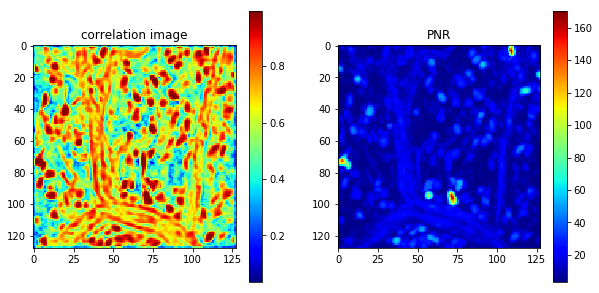

In [5]:
# pick thresholds 
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(cn_filter, cmap='jet')
plt.title('correlation image')
plt.colorbar()
plt.subplot(122)
plt.imshow(pnr, cmap='jet')
plt.title('PNR')
plt.colorbar()

neuron.update_options('min_corr=0.85', 'min_pnr=20')

In [6]:
importlib.reload(cnmfe)
%matplotlib inline
results = cnmfe.greedy_roi_corr(Y, max_number=[], options=neuron.options, debug_on=False)

0 neurons have been initialized
10 neurons have been initialized
20 neurons have been initialized
30 neurons have been initialized
40 neurons have been initialized
50 neurons have been initialized
60 neurons have been initialized
70 neurons have been initialized
80 neurons have been initialized
90 neurons have been initialized
100 neurons have been initialized
110 neurons have been initialized
120 neurons have been initialized
130 neurons have been initialized
In total,  133 neurons were initialized.


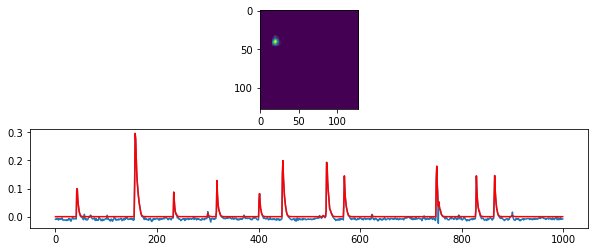

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(211)
m = 10
plt.imshow(results['A'][m, :, :])
plt.subplot(212)
plt.plot(results['C_raw'][m])
plt.plot(results['C'][m], 'r')